In [4]:
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, "..")

import scipy.signal

from im_processing_fct.functions import *

In [5]:
PathTemp = Path("/mnt/labserver/DURRIEU_Matthias/Experimental_data/TrackingFiles/BackgroundImages/outer_arena_MultinazeBiS_Spacer/MultiMazeBiS_Empty/Spacer/221206/095129_s0a0_p6-0/Sample/MultiMaze_Spacer_Template.jpg")

In [6]:
VideoPath = Path('/mnt/labserver/DURRIEU_Matthias/Experimental_data/Optogenetics/Optobot/MultiMazeBiS_15_Steel_Wax/Female_Starved_noWater/221116/102044_s0a0_p6-0/Arena1.mp4')

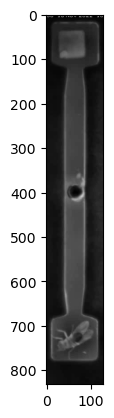

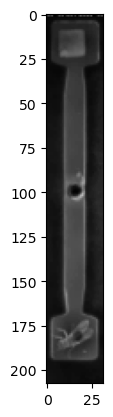

In [7]:
vidcap = cv2.VideoCapture(VideoPath.as_posix())
for i in range(1):
    success,im_full = vidcap.read()

im_full_gray = cv2.cvtColor(im_full, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(im_full_gray, cmap='gray', vmin=0, vmax=255)

im_full_gray_resized = cv2.resize(im_full_gray, (int(im_full_gray.shape[1]/rescaling_factor),
                                       int(im_full_gray.shape[0]/rescaling_factor)),
                            interpolation = cv2.INTER_AREA)

plt.figure()
plt.imshow(im_full_gray_resized, cmap='gray', vmin=0, vmax=255)

In [ ]:
res_val = math.inf
for i in range(10):
    background_full_temp = gen_background(im_full_gray_resized)

    im_gray_resized_bg_full_sub = cv2.subtract(im_full_gray_resized, background_full_temp)
    if (res_val > cv2.sumElems(im_gray_resized_bg_full_sub)[0]):
        res_val = cv2.sumElems(im_gray_resized_bg_full_sub)[0]
        print(res_val)
        background_full = background_full_temp.copy()
        background_arena_door = background_arena_door_temp.copy()
        background_rails = background_rails_temp.copy()

    success,im_full = vidcap.read()
    im_full_gray = cv2.cvtColor(im_full, cv2.COLOR_BGR2GRAY)
    im_full_gray_resized = cv2.resize(im_full_gray, (int(im_full_gray.shape[1]/rescaling_factor),
                                      int(im_full_gray.shape[0]/rescaling_factor)),
                                      interpolation = cv2.INTER_AREA)



plt.figure()
plt.imshow(background_arena_door, cmap='gray', vmin=0, vmax=255)
plt.figure()
plt.imshow(background_rails, cmap='gray', vmin=0, vmax=255)
plt.figure()
plt.imshow(background_full, cmap='gray', vmin=0, vmax=255)

In [ ]:
def gen_background(im_full_gray):
    background_full = np.zeros(im_full_gray.shape, np.uint8)

    # reading images of background elements
    im_arena_door_gray = cv2.cvtColor(cv2.imread("/mnt/labserver/DURRIEU_Matthias/Experimental_data/TrackingFiles/BackgroundImages/outer_arena_MultinazeBiS_Spacer/MultiMazeBiS_Empty/Spacer/221206/095129_s0a0_p6-0/Sample/img_0/Arena1.jpg"), cv2.COLOR_BGR2GRAY)
    im_arena_door_gray_unif = cv2.cvtColor(cv2.imread("/mnt/labserver/DURRIEU_Matthias/Experimental_data/TrackingFiles/BackgroundImages/outer_arena_MultinazeBiS_Spacer/MultiMazeBiS_Empty/Spacer/221206/095129_s0a0_p6-0/Sample/MultiMaze_Spacer_Template.jpg"), cv2.COLOR_BGR2GRAY)

    # resizing elements
    im_arena_door_gray_resized = cv2.resize(im_arena_door_gray, (im_full_gray.shape[1], im_full_gray.shape[0]),
                                            interpolation=cv2.INTER_AREA)
    im_arena_door_gray_unif_resized = cv2.resize(im_arena_door_gray_unif,
                                                 (im_full_gray.shape[1], im_full_gray.shape[0]),
                                                 interpolation=cv2.INTER_AREA)

    # arena and door
    im_size = im_full_gray.shape
    H_arena_door = compute_homography_orb(im_arena_door_gray_resized, im_full_gray)  # 500, 0.85
    im_arena_door_gray_unif_resized_trans = cv2.warpAffine(im_arena_door_gray_unif_resized, H_arena_door, im_size)

    im_arena_door_gray_unif_resized_trans = cv2.dilate(im_arena_door_gray_unif_resized_trans, np.ones((2, 2), np.uint8))
    background_full = cv2.add(background_full, im_arena_door_gray_unif_resized_trans)
    background_arena_door = cv2.add(background_arena_door, im_arena_door_gray_unif_resized_trans)

    # plt.figure()
    # plt.imshow(background_full)

    im_full_gray_ad = cv2.subtract(im_full_gray, im_arena_door_gray_unif_resized_trans)

    # finding longest (outer) contour
    for i in range(len(im_rail_contours)):
        im_rail_contours_len.append(len(im_rail_contours[i]))
    im_rail_contours_max_len_idx = np.argmax(im_rail_contours_len)

    contour_to_match = im_rail_contours[im_rail_contours_max_len_idx]
    rows, cols = im_full_gray_adr_temp.shape

    for i in range(nb_rails):
        contour_found = contour_matching(im_full_gray_adr_temp, contour_to_match)

        mask = np.zeros(im_full_gray_adr_temp.shape)
        mask = cv2.drawContours(image=mask, contours=[contour_found], contourIdx=-1,
                                color=1, thickness=cv2.FILLED, lineType=cv2.LINE_AA)
        # plt.figure()
        # plt.imshow(mask)
        # plt.title("mask")

        im_full_gray_adr_temp[mask == 1] = 0

        cx, cy, alpha = compute_centroid_angle(mask)
        # print(cx,cy,alpha)

        # rotation
        M = cv2.getRotationMatrix2D((rows / 2, cols / 2), alpha, 1)
        rot = cv2.warpAffine(im_rail_gray_to_sub, M, (rows, cols))

        dist_to_center_x = cx - rows / 2
        dist_to_center_y = cy - cols / 2
        # translation
        M = np.float32([[1, 0, dist_to_center_x], [0, 1, dist_to_center_y]])
        trans = cv2.warpAffine(rot, M, (rows, cols))

        background_full = cv2.add(background_full, trans)
        background_rails = cv2.add(background_rails, trans)

        im_full_gray_adr = cv2.subtract(im_full_gray_adr, trans)

    return background_arena_door, background_rails, background_full

In [8]:
img = im_full_gray_resized
img2 = img.copy()
template = cv2.imread(PathTemp.as_posix(),0)
w, h = template.shape[::-1]


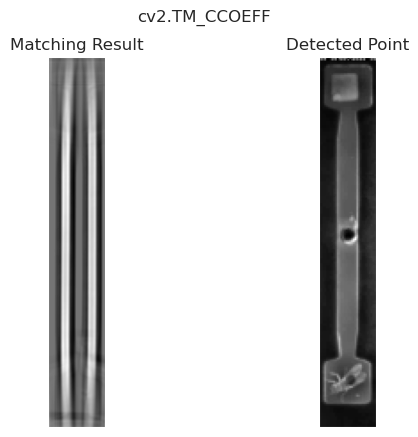

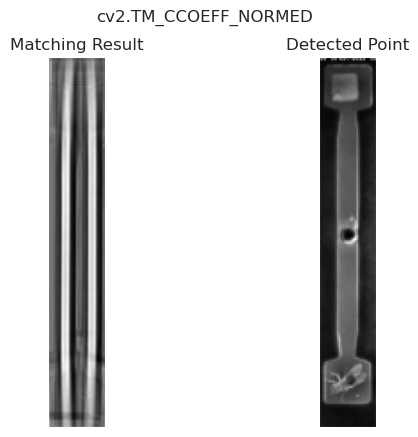

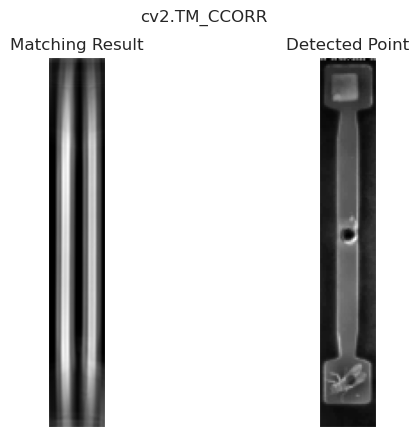

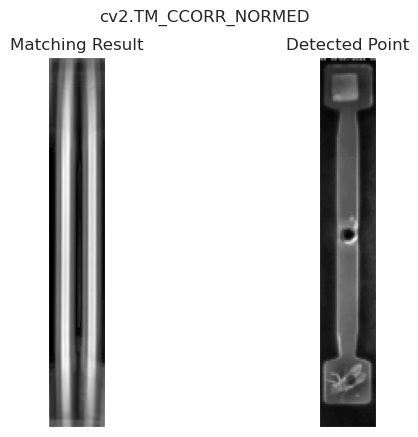

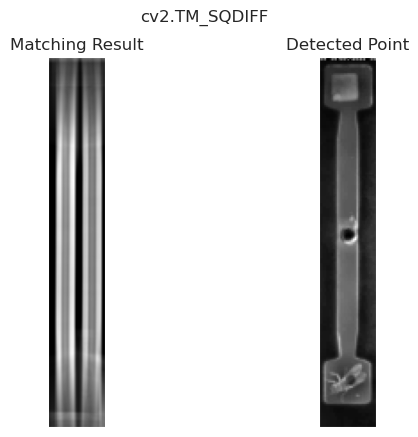

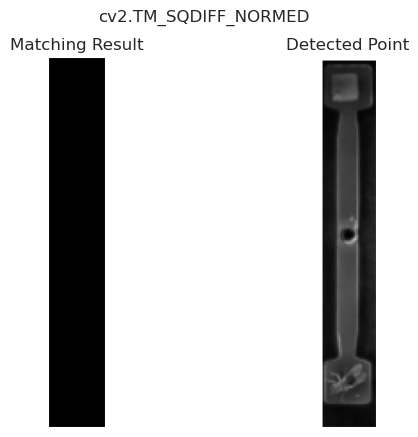

In [8]:

# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
for meth in methods:
    img = img2.copy()
    method = eval(meth)
    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(img,top_left, bottom_right, 255, 2)
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()

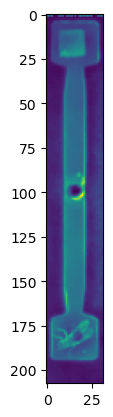

In [9]:
img = im_full_gray_resized
img2 = img.copy()
template = cv2.imread(PathTemp.as_posix(),0)

plt.imshow(img)

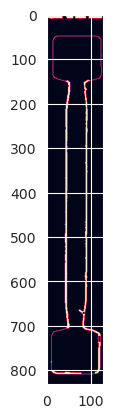

In [10]:
plt.imshow(template)

In [11]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
# No need to do this as images are already gray

error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [10]:
tempmatch = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)

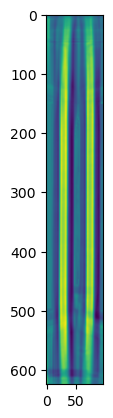

In [11]:
plt.imshow(tempmatch)

In [8]:
Subtest = cv2.absdiff(img,tempmatch)

error: OpenCV(4.6.0) /io/opencv/modules/core/src/arithm.cpp:647: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


In [9]:
(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(tempmatch)

In [10]:
(startX, startY) = maxLoc
endX = startX + template.shape[1]
endY = startY + template.shape[0]

In [11]:
# draw the bounding box on the image
cv2.rectangle(img, (startX, startY), (endX, endY), (255, 0, 0), 3)
# show the output image
cv2.imshow("Output", img)
#cv2.waitKey(0)

QObject::moveToThread: Current thread (0x4348010) is not the object's thread (0x42669e0).
Cannot move to target thread (0x4348010)

QObject::moveToThread: Current thread (0x4348010) is not the object's thread (0x42669e0).
Cannot move to target thread (0x4348010)

QObject::moveToThread: Current thread (0x4348010) is not the object's thread (0x42669e0).
Cannot move to target thread (0x4348010)

QObject::moveToThread: Current thread (0x4348010) is not the object's thread (0x42669e0).
Cannot move to target thread (0x4348010)

QObject::moveToThread: Current thread (0x4348010) is not the object's thread (0x42669e0).
Cannot move to target thread (0x4348010)

QObject::moveToThread: Current thread (0x4348010) is not the object's thread (0x42669e0).
Cannot move to target thread (0x4348010)

QObject::moveToThread: Current thread (0x4348010) is not the object's thread (0x42669e0).
Cannot move to target thread (0x4348010)

QObject::moveToThread: Current thread (0x4348010) is not the object's thread

In [22]:
im_resized = cv2.resize(im_full_gray, (int(im_full_gray.shape[1]/rescaling_factor),
                                          int(im_full_gray.shape[0]/rescaling_factor)),
                                          interpolation = cv2.INTER_AREA)
template_resized = cv2.resize(template, (int(im_full_gray.shape[1]/rescaling_factor),
                                          int(im_full_gray.shape[0]/rescaling_factor)),
                                          interpolation = cv2.INTER_AREA)

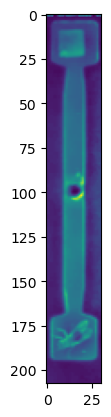

In [23]:
plt.imshow(img_resized)

In [24]:
remarena = cv2.subtract(img, template)

error: OpenCV(4.6.0) /io/opencv/modules/core/src/arithm.cpp:647: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'
